In [1]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Задание

Реализуйте поиск по [Quora question pairs](https://www.kaggle.com/loopdigga/quora-question-pairs-russian) на нескольких векторных моделях

    1. fasttext, модель ruscorpora_none_fasttextskipgram_300_2_2019
    2. elmo, модель ruwikiruscorpora_lemmas_elmo_1024_2019
    3. bert*, RuBERT - необязательно
   
Первые две обученные модели можно скачать на сайте [rusvectores](https://rusvectores.org/en/models/).

BERT делать необязательно, но если сделаете, 6 за курс у вас автоматом. Модель можно [найти тут](http://docs.deeppavlov.ai/en/master/features/models/bert.html).

### __Задача 1__:    
Сравните время индексации корпуса для каждой модели 

In [2]:
# import libraries
import csv
import os
from math import log
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from string import punctuation
punctuation += '…—'
!pip install pymorphy2[fast]
from pymorphy2 import MorphAnalyzer
import time
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
import sys
import warnings
warnings.filterwarnings('ignore')
# ~ global variables
pymorphy2_analyzer = MorphAnalyzer()
rus_stopwords = stopwords.words('russian')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eduard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eduard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# In Google Colab add the following prefix
colab_prefix = '/content/drive/My Drive'

##### Retrieve queries and docs 

In [3]:
# colab_prefix + 
with open('quora_question_pairs_rus.csv', 'r', encoding='utf-8') as f:
    csv_reader = csv.reader(f)
    # skip the header
    print('header:', next(csv_reader, None))
    queries = []
    docs = []
    answers = []
    for row in csv_reader:
        for _, query, doc, answer in csv_reader:
            queries.append(query)
            docs.append(doc)
            answers.append(int(float(answer)))

header: ['', 'question1', 'question2', 'is_duplicate']


In [4]:
# функция препроцессинга данных
def preprocess_text(text, save_stopwords=True):
    lowered_tokens = [word.strip(punctuation) for word in word_tokenize(text.lower()) if word.strip(punctuation)]
    if save_stopwords:
        return [pymorphy2_analyzer.normal_forms(token)[0] for token in lowered_tokens]
    return [pymorphy2_analyzer.normal_forms(token)[0] for token in lowered_tokens if pymorphy2_analyzer.normal_forms(token)[0] not in rus_stopwords]

In [5]:
# preprocess only first 1000 docs as elmo works too long and bert works even longer...
N = 1000
tokenized_docs = [preprocess_text(doc) for doc in docs[:N]]

##### Fasttext

In [6]:
from gensim.models.keyedvectors import KeyedVectors

model_file = os.path.join(os.getcwd(), '181', 'model.model')

fasttext_model = KeyedVectors.load(model_file)

In [7]:
def get_fasttext_vector(tokenized_doc, fasttext_model):
    # создаем маски для векторов
    lemmas_vectors = np.zeros((len(tokenized_doc), fasttext_model.vector_size))
    vec = np.zeros((fasttext_model.vector_size,))

    # если слово есть в модели, берем его вектор
    for idx, lemma in enumerate(tokenized_doc):
        if lemma in fasttext_model.vocab:
            lemmas_vectors[idx] = fasttext_model.wv[lemma]

    return np.mean(lemmas_vectors, axis=0)

In [8]:
%%time
fasttext_vectors = np.zeros((len(tokenized_docs), fasttext_model.vector_size))

for doc_index, tokenized_doc in enumerate(tokenized_docs):
    fasttext_vectors[doc_index] = get_fasttext_vector(tokenized_doc, fasttext_model)

Wall time: 190 ms


##### Elmo

In [9]:
from bilm import Batcher, BidirectionalLanguageModel, weight_layers
import tensorflow as tf

def load_elmo_embeddings(directory, top=False):
    """
    :param directory: directory with an ELMo model ('model.hdf5', 'options.json' and 'vocab.txt.gz')
    :param top: use ony top ELMo layer
    :return: ELMo batcher, character id placeholders, op object
    """
    vocab_file = os.path.join(directory, 'vocab.txt')
    options_file = os.path.join(directory, 'options.json')
    weight_file = os.path.join(directory, 'model.hdf5')

    # Create a Batcher to map text to character ids.
    batcher = Batcher(vocab_file, 50)

    # Input placeholders to the biLM.
    sentence_character_ids = tf.placeholder('int32', shape=(None, None, 50))

    # Build the biLM graph.
    bilm = BidirectionalLanguageModel(options_file, weight_file, max_batch_size=300)

    # Get ops to compute the LM embeddings.
    sentence_embeddings_op = bilm(sentence_character_ids)

    # Get an op to compute ELMo (weighted average of the internal biLM layers)
    elmo_sentence_input = weight_layers('input', sentence_embeddings_op, use_top_only=top)
    return batcher, sentence_character_ids, elmo_sentence_input

In [10]:
def get_elmo_vectors(sess, texts, batcher, sentence_character_ids, elmo_sentence_input):
    """
    :param sess: TensorFlow session
    :param texts: list of sentences (lists of words)
    :param batcher: ELMo batcher object
    :param sentence_character_ids: ELMo character id placeholders
    :param elmo_sentence_input: ELMo op object
    :return: embedding matrix for all sentences (max word count by vector size)
    """

    # Create batches of data.
    sentence_ids = batcher.batch_sentences(texts)
    print('Sentences in this batch:', len(texts), file=sys.stderr)

    # Compute ELMo representations.
    elmo_sentence_input_ = sess.run(elmo_sentence_input['weighted_op'],
                                    feed_dict={sentence_character_ids: sentence_ids})

    return elmo_sentence_input_

In [11]:
# переделать на os.path.join() с подпапкой
batcher, sentence_character_ids, elmo_sentence_input = load_elmo_embeddings(os.path.join(os.getcwd(), '196'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


In [12]:
%%time

#         embedding_op computes the LM embeddings and is shape
#             (None, 3, None, 1024) (c) docs
elmo_vector_size = 1024
elmo_vectors = np.zeros((len(tokenized_docs), elmo_vector_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch_size = 300
    for i in range(0, len(tokenized_docs), batch_size):
        elmo_vectors[i:i + batch_size] = np.mean(get_elmo_vectors(
            sess, tokenized_docs[i:i + batch_size], batcher, sentence_character_ids, elmo_sentence_input), axis=1)

Sentences in this batch: 300
Sentences in this batch: 300
Sentences in this batch: 300
Sentences in this batch: 100


Wall time: 2min 45s


In [13]:
print('Tensor shape:', elmo_vectors.shape)

Tensor shape: (1000, 1024)


##### Bert

In [9]:
import keras
!pip install keras_bert
from keras_bert import load_vocabulary, load_trained_model_from_checkpoint, Tokenizer, get_checkpoint_paths
from keras_bert.layers import MaskedGlobalMaxPool1D

Using TensorFlow backend.


  Created wheel for keras-bert: filename=keras_bert-0.79.0-cp36-none-any.whl size=37973 sha256=7e9354d5f51f61d835abfe15ca9296e96f0d78fcf72f2db67ca2db87528519ef
  Stored in directory: /root/.cache/pip/wheels/1e/3d/f6/5785f07131994c4af150afc4d09470c811af541f79e266e50e
  Created wheel for keras-transformer: filename=keras_transformer-0.31.0-cp36-none-any.whl size=13385 sha256=f44a9b85a45838d2b370dad9ad6fb9df83bc0e79500bde0b7c09dba98a7bd398
  Stored in directory: /root/.cache/pip/wheels/a3/c5/9a/5a5130240be614a7a6fa786765d7692ae97f82601e2161bb56
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=0e488c52f392f5c0a897e0691804755c3cf6b8479df6c90e54702fb8fd5f8225
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=d8ec1ec5454ee891f8f3844a6ddb7ae1632d74dd6595ae933b14fc02abc0dc64
  Stor

In [0]:
model_path = '/content/drive/My Drive/bert'
paths = get_checkpoint_paths(model_path)

In [0]:
seq_len = 50
bert_model = load_trained_model_from_checkpoint(config_file=paths.config, checkpoint_file=paths.checkpoint, seq_len=seq_len)

In [0]:
pool_layer = MaskedGlobalMaxPool1D(name='Pooling')(bert_model.output)

In [0]:
bert_model = keras.models.Model(inputs=bert_model.inputs, outputs=pool_layer)

In [0]:
token_dict = load_vocabulary(paths.vocab)
tokenizer = Tokenizer(token_dict)

In [0]:
def get_bert_vector(doc, bert_model, token_dict, seq_len):
    tokenized_doc = tokenizer.tokenize(doc)[:seq_len]
    segments = [0] * seq_len
    indices = [token_dict[elem] for elem in tokenized_doc]
    indices += [0] * (seq_len - len(indices))
    return bert_model.predict([np.array([indices]), np.array([segments])])[0]

In [27]:
%%time
bert_vector_size = 768
bert_vectors = np.zeros((len(tokenized_docs), bert_vector_size))

for i, tokenized_doc in enumerate(tokenized_docs):
    bert_vectors[i] = get_bert_vector(' '.join(tokenized_doc), bert_model, token_dict, seq_len)

CPU times: user 18.3 s, sys: 1.7 s, total: 20 s
Wall time: 22.4 s


### __Задача 2__:    
Выведите качество поиска для каждой модели +  BM25 для сравнения

Качество оцениваем так же, как в прошлом задании:
    - если в топ-5 результатов выдачи попал хоть один релевантный документ, выдача точная
    - если в топ-5 нет ни одного релеватного документа, выдача получает 0
   

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
def get_most_probable_docs(doc_vector, docs_matrix):
    cosine_values = cosine_similarity(docs_matrix, doc_vector.reshape(1, -1)).reshape(docs_matrix.shape[0])
    return [docs[doc_id] for doc_id, _ in sorted(list(
        enumerate(cosine_values)), key=lambda elem: elem[1], reverse=True)]

In [15]:
def search_fasttext(query, fasttext_model, fasttext_vectors):
    return get_most_probable_docs(get_fasttext_vector(preprocess_text(query), fasttext_model), fasttext_vectors)

In [16]:
def search_elmo(query, elmo_vectors, sess, batcher, sentence_character_ids, elmo_sentence_input):
    tokenized_query = preprocess_text(query)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        elmo_vector = np.mean(get_elmo_vectors(
            sess, [tokenized_query], batcher, sentence_character_ids, elmo_sentence_input), axis=1)[0]
    return get_most_probable_docs(elmo_vector, elmo_vectors)

In [0]:
def search_bert(query, bert_vectors, bert_model, token_dict, seq_len):
    bert_vector = get_bert_vector(query, bert_model, token_dict, seq_len)
    return get_most_probable_docs(bert_vector, bert_vectors)

In [17]:
results = search_fasttext('почему я чувствую, что я взволнован чем-то', fasttext_model, fasttext_vectors)
print('\n'.join([f'{i + 1} - {elem}' for i, elem in enumerate(results[:5])]))

1 - почему я чувствую, что я взволнован чем-то, когда мне нечего волноваться
2 - почему люди ненавидят шарух хана и почему люди чувствуют, что он не индийский
3 - парень, с которым я встречаюсь, никогда не пишет меня, и я чувствую, что он не заботится обо мне, но когда я вижу его, он показывает мне, что он любит меня и хочет меня, почему я так себя чувствую
4 - почему большинство парней в Индии становятся настолько отчаянными, что они не знают, что девочки не всегда ищут отношения, это повредит парням, чтобы стать нашим другом первым
5 - почему я хочу остаться одиноким всю свою жизнь после моего распада, почему я чувствую, что я закончил эту серьезную связь


In [18]:
results = search_elmo('почему я чувствую, что я взволнован чем-то', elmo_vectors, sess, batcher, sentence_character_ids, elmo_sentence_input)
print('\n'.join([f'{i + 1} - {elem}' for i, elem in enumerate(results[:5])]))

Sentences in this batch: 1


1 - почему я чувствую, что я взволнован чем-то, когда мне нечего волноваться
2 - парень, с которым я встречаюсь, никогда не пишет меня, и я чувствую, что он не заботится обо мне, но когда я вижу его, он показывает мне, что он любит меня и хочет меня, почему я так себя чувствую
3 - как я могу избавиться от чувства, что мой супруг обманывает меня?
4 - почему я хочу остаться одиноким всю свою жизнь после моего распада, почему я чувствую, что я закончил эту серьезную связь
5 - как мне пережить кого-то, кого я любил сейчас, когда мы расстались в прошлом году, и я все еще скучаю по ней


In [32]:
results = search_bert('почему я чувствую, что я взволнован чем-то', bert_vectors, bert_model, token_dict, seq_len)
print('\n'.join([f'{i + 1} - {elem}' for i, elem in enumerate(results[:5])]))

1 - почему я чувствую, что я взволнован чем-то, когда мне нечего волноваться
2 - почему я не хочу разговаривать с кем-то
3 - что я могу сделать, чтобы не ревновать кого-то
4 - как я перестаю быть зависимым от кого-то
5 - как я должен перестать думать о ком-то


In [0]:
def count_bert_precision(num_of_docs=1000):
    tp = 0
    fp = 0
    for query, doc, answer in zip(queries[:num_of_docs], docs[:num_of_docs], answers[:num_of_docs]):
        results = search_bert(query, bert_vectors, bert_model, token_dict, seq_len)
        if doc in results[:5]:
            if answer:
                tp += 1
            else:
                fp += 1
    return tp / (tp + fp)

In [34]:
bert_precision = count_bert_precision()
bert_precision

0.49643705463182897

In [19]:
def count_elmo_precision(num_of_docs=1000):
    tokenized_queries = [preprocess_text(query) for query in queries[:num_of_docs]]
    elmo_query_vectors = np.zeros((num_of_docs, elmo_vector_size))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_size = 300
        for i in range(0, num_of_docs, batch_size):
            elmo_query_vectors[i:i + batch_size] = np.mean(get_elmo_vectors(
                sess, tokenized_queries[i:i + batch_size], batcher, sentence_character_ids, elmo_sentence_input), axis=1)

    tp = 0
    fp = 0
    for elmo_query_vector, doc, answer in zip(elmo_query_vectors, docs[:num_of_docs], answers[:num_of_docs]):
        results = get_most_probable_docs(elmo_query_vector, elmo_vectors)
        if doc in results[:5]:
            if answer:
                tp += 1
            else:
                fp += 1
    return tp / (tp + fp)

In [20]:
elmo_precision = count_elmo_precision()
elmo_precision

Sentences in this batch: 300
Sentences in this batch: 300
Sentences in this batch: 300
Sentences in this batch: 100


0.48462664714494874

In [21]:
def count_fasttext_precision(num_of_docs=1000):
    tp = 0
    fp = 0
    for query, doc, answer in zip(queries[:num_of_docs], docs[:num_of_docs], answers[:num_of_docs]):
        results = search_fasttext(query, fasttext_model, fasttext_vectors)
        if doc in results[:5]:
            if answer:
                tp += 1
            else:
                fp += 1
    return tp / (tp + fp)

In [22]:
fasttext_precision = count_fasttext_precision()
fasttext_precision

0.4778625954198473

In [23]:
# см. предыдущую домашнюю работу (b=1, num_of_docs=1000)
bm25_precision = 0.5386029411764706

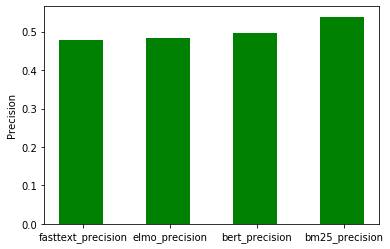

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
rects = ax.bar(range(4), [fasttext_precision, elmo_precision, bert_precision, bm25_precision], 0.5, color='g')
ax.set_ylabel('Precision')
ax.set_xticks(np.add(range(4), 1/50))
ax.set_xticklabels((['fasttext_precision', 'elmo_precision', 'bert_precision', 'bm25_precision']))

plt.show()